In [132]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from scipy.sparse import hstack
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix

import seaborn as sns
import itertools
import matplotlib.pyplot as plt

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:



Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол


Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза


Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность


Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

In [133]:
df = pd.read_csv('/Users/ilburtsev/Documents/ML_business/data/train_case2.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Разделим данные на тренировучную и тестовую выборку

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),
                                                    df['cardio'], random_state=17)

C:\Users\ilburtsev\AppData\Local\Temp\ipykernel_8144\3195829064.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1),


К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [135]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    '''
    Transformer to select a single column from the data frame to perform additional transformations on
    '''
    def __init__(self, key):
        self.key = key

    def fit (self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    '''
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    '''
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [136]:
from sklearn.preprocessing import StandardScaler

continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for col_continu in continuos_cols:
    transformer = Pipeline([
            ('selector', NumberSelector(key=col_continu)),
            ('standard', StandardScaler())
        ])
    continuos_transformers.append((col_continu, transformer))

for col_cat in cat_cols:
    cat_transformer = Pipeline([
            ('selector', NumberSelector(key=col_cat)),
            ('ohe', OHEEncoder(key=col_cat))
        ])
    cat_transformers.append((col_cat, cat_transformer))

for col_base in base_cols:
    base_transformer = Pipeline([
            ('selector', NumberSelector(key=col_base))
        ])
    base_transformers.append((col_base, base_transformer))


Теперь объединим все наши трансформеры с помощью FeatureUnion

In [137]:
from sklearn.pipeline import FeatureUnion

feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.39520999, -0.04329932, -0.28987269, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.67623696,  0.19974721, -0.63706182, ...,  0.        ,
         0.        ,  1.        ],
       [-1.34332247, -0.16482258,  0.2656299 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.10618031, -0.16482258,  0.19619208, ...,  0.        ,
         0.        ,  1.        ],
       [-1.16495913, -0.52939237, -0.70649964, ...,  0.        ,
         0.        ,  1.        ],
       [-2.06569399,  1.05041005,  0.82113249, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [138]:
classifier = Pipeline([
    ('features', feats),
    ('classifier', LogisticRegression(random_state=17))
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

# обучим пайплайн на всем тренировочном датасете
classifier.fit(X_train, y_train)
y_score = classifier.predict_proba(X_test)[:, 1]
print(y_score)

CV score is 0.7867861709946173+-0.009757913277648158
[0.44452899 0.48977033 0.75597095 ... 0.17836344 0.35732103 0.63082293]


Посчитаем precision/recall/f_score

In [139]:
b = 1
precision, recall, thresholds = precision_recall_curve(y_test.values, y_score)
fscore = (1 + b**2)*(precision * recall) / (b ** 2*precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix],
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.382173, F-Score=0.735, Precision=0.650, Recall=0.846


Нарисуем roc auc кривую

In [140]:
# функция roc_auc кривой
def roc_graph(y_test, y_score):
    sns.set(font_scale=1.5)
    sns.set_color_codes('muted')

    plt.figure(figsize=(8, 8))
    fpr, tpr, thresholds_ = roc_curve(y_test, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.savefig('ROC.png')
    plt.show()

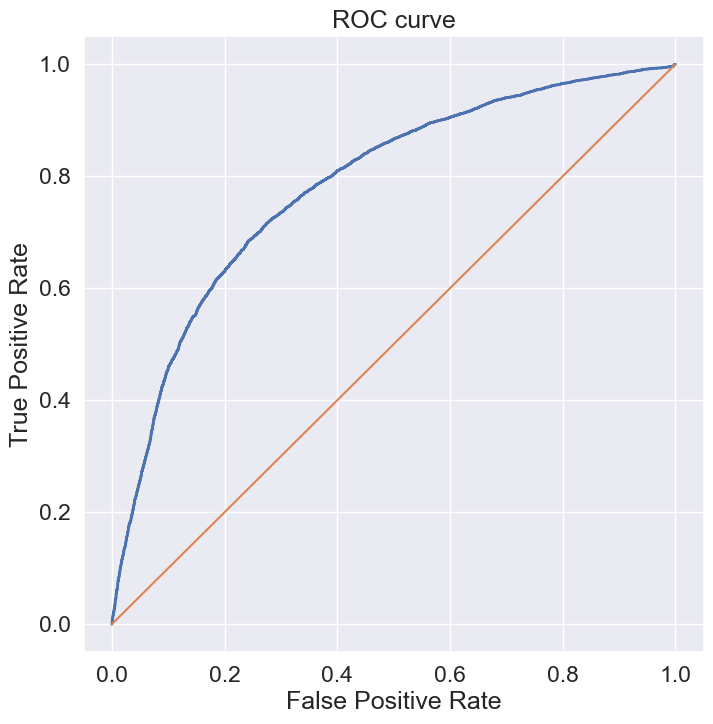

In [141]:
roc_graph(y_test, y_score)

In [142]:
from sklearn.metrics import roc_auc_score, log_loss


print('roc auc score: {}'.format(roc_auc_score(y_true=y_test, y_score=y_score)))
print('log loss score: {}'.format(log_loss(y_true=y_test, y_pred=y_score)))

roc auc score: 0.783289985546442
log loss score: 0.5773377314271202


Посмотрим на матрицу ошибок

In [143]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
     """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
     plt.imshow(cm, interpolation='nearest',cmap=cmap)
     plt.title(title)
     plt.colorbar()
     tick_marks = np.arange(len(classes))
     plt.xticks(tick_marks, classes, rotation=45)
     plt.yticks(tick_marks, classes)

     if normalize:
         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
         print('Normalized confusion matrix')
     else:
         print('Confusion matrix, without normalization')

     print(cm)

     thresh = cm.max() / 2.
     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
         plt.text(j, i, cm[i, j],
                  horizontalalignment='center',
                  color='white' if cm[i, j] > thresh else 'black')

     plt.tight_layout()
     plt.ylabel('True label')
     plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[4727 3996]
 [1351 7426]]


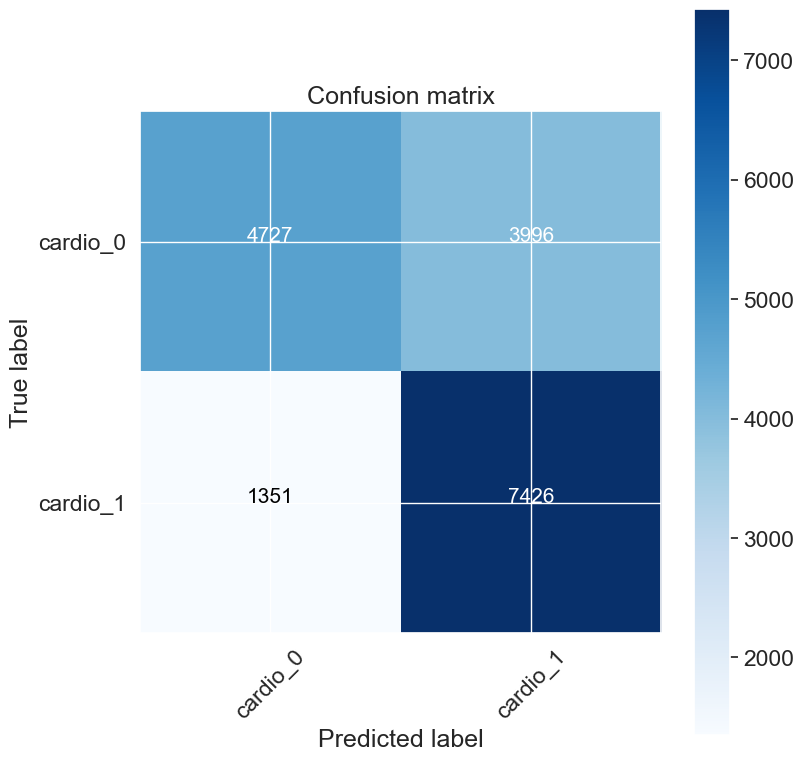

In [144]:
# мы уже нашли оптимальный порог, который максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)
cnf_matrix = confusion_matrix(y_test, y_score>thresholds[ix])
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                      title='Confusion matrix')
plt.savefig('conf_matrix.png')
plt.show()

Посчитаем FPR, TPR

In [145]:
TN = cnf_matrix[0][0]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]
FP = cnf_matrix[0][1]

TPR = TP / (TP+FN)
FPR = FP / (FP+TN)
TNR = TN / (FP+TN)
TPR, FPR, TNR

(0.8460749686681098, 0.4580992777714089, 0.5419007222285911)

False Positive Rate довольно высокий ~ 0.45
Это означает, что 45 процентов всех пациентов получат метку 1 при том, что они на самом деле здоровы
Хорошая ли модель у нас получилась? - ответ сильно зависит от внешних факторов

In [146]:
# XGBClassifier
from xgboost import XGBClassifier
classifier_xgb = Pipeline([
    ('features',feats),
    ('classifier', XGBClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_xgb, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_xgb.fit(X_train, y_train)
y_score = classifier_xgb.predict(X_test)

CV score is 0.7973464456239558+-0.009350668739445478


In [147]:
b = 1
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test.values, y_score)
fscore_xgb = (1 + b**2)*(precision_xgb * recall_xgb) / (b ** 2*precision_xgb + recall_xgb)
ix_xgb = np.argmax(fscore_xgb)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_xgb[ix_xgb],
                                                                        fscore_xgb[ix_xgb],
                                                                        precision_xgb[ix_xgb],
                                                                        recall_xgb[ix_xgb]))
roc_auc_score_xgb = roc_auc_score(y_true=y_test, y_score=y_score)
log_loss_xgb = log_loss(y_true=y_test, y_pred=y_score)

Best Threshold=1.000000, F-Score=0.724, Precision=0.754, Recall=0.696


In [148]:
# CatBoost
from catboost import CatBoostClassifier
classifier_cat = Pipeline([
    ('features',feats),
    ('classifier',  CatBoostClassifier()),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_cat, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_cat.fit(X_train, y_train)
y_score = classifier_cat.predict(X_test)

Learning rate set to 0.054384
0:	learn: 0.6773354	total: 20.9ms	remaining: 20.9s
1:	learn: 0.6627893	total: 27.5ms	remaining: 13.7s
2:	learn: 0.6501460	total: 34.8ms	remaining: 11.6s
3:	learn: 0.6393143	total: 43.9ms	remaining: 10.9s
4:	learn: 0.6295301	total: 51.9ms	remaining: 10.3s
5:	learn: 0.6205169	total: 60.1ms	remaining: 9.95s
6:	learn: 0.6126942	total: 67.4ms	remaining: 9.56s
7:	learn: 0.6053460	total: 75.2ms	remaining: 9.33s
8:	learn: 0.5990041	total: 82.7ms	remaining: 9.11s
9:	learn: 0.5933855	total: 90.1ms	remaining: 8.92s
10:	learn: 0.5883432	total: 98.3ms	remaining: 8.84s
11:	learn: 0.5840464	total: 105ms	remaining: 8.61s
12:	learn: 0.5801777	total: 112ms	remaining: 8.53s
13:	learn: 0.5767597	total: 121ms	remaining: 8.49s
14:	learn: 0.5735173	total: 128ms	remaining: 8.43s
15:	learn: 0.5703386	total: 137ms	remaining: 8.4s
16:	learn: 0.5675615	total: 144ms	remaining: 8.33s
17:	learn: 0.5651618	total: 152ms	remaining: 8.29s
18:	learn: 0.5627851	total: 160ms	remaining: 8.24s
1

In [149]:
b = 1
precision_cat, recall_cat, thresholds_cat = precision_recall_curve(y_test.values, y_score)
fscore_cat = (1 + b**2)*(precision_cat * recall_cat) / (b ** 2*precision_cat + recall_cat)
ix_cat = np.argmax(fscore_cat)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_cat[ix_cat],
                                                                        fscore_cat[ix_cat],
                                                                        precision_cat[ix_cat],
                                                                        recall_cat[ix_cat]))
roc_auc_score_cat = roc_auc_score(y_true=y_test, y_score=y_score)
log_loss_cat = log_loss(y_true=y_test, y_pred=y_score)

Best Threshold=1.000000, F-Score=0.728, Precision=0.754, Recall=0.703


In [150]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

classifier_tree = Pipeline([
    ('features',feats),
    ('classifier',  DecisionTreeClassifier(min_samples_split = 30)),
])


#запустим кросс-валидацию
cv_scores = cross_val_score(classifier_tree, X_train, y_train, cv=16, scoring='roc_auc')
cv_score = np.mean(cv_scores)
cv_score_std = np.std(cv_scores)
print('CV score is {}+-{}'.format(cv_score, cv_score_std))

#обучим пайплайн на всем тренировочном датасете
classifier_tree.fit(X_train, y_train)
y_score = classifier_tree.predict(X_test)

CV score is 0.7235550378012097+-0.009837250720070783


In [151]:
b = 1
precision_tree, recall_tree, thresholds_tree = precision_recall_curve(y_test.values, y_score)
fscore_tree = (1 + b**2)*(precision_tree * recall_tree) / (b ** 2*precision_tree + recall_tree)
ix_tree = np.argmax(fscore_tree)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_tree[ix_tree],
                                                                        fscore_tree[ix_tree],
                                                                        precision_tree[ix_tree],
                                                                        recall_tree[ix_tree]))
roc_auc_score_tree = roc_auc_score(y_true=y_test, y_score=y_score)
log_loss_tree = log_loss(y_true=y_test, y_pred=y_score, normalize=True)

Best Threshold=1.000000, F-Score=0.673, Precision=0.684, Recall=0.661


In [152]:
print(f'Log_reg - Precision: {precision[ix]:.2f}, Recall: {recall[ix]:.2f}, F-score: {fscore[ix]:.2f}, ROC_AUC: {0.783289985546442:.2f}, LOG_LOSS: {0.5773377314271202:.2f}\nXGBClassifier - Precision: {precision_xgb[ix_xgb]:.2f}, Recall: {recall_xgb[ix_xgb]:.2f}, F-score: {fscore_xgb[ix_xgb]:.2f}, ROC_AUC: {roc_auc_score_xgb:.2f}, LOG_LOSS: {log_loss_xgb:.2f}\nCatBoost - Precision: {precision_cat[ix_cat]:.2f}, Recall: {recall_cat[ix_cat]:.2f}, F-score: {fscore_cat[ix_cat]:.2f}, ROC_AUC: {roc_auc_score_cat:.2f}, LOG_LOSS: {log_loss_cat:.2f}\nDecisionTreeClassifier - Precision: {precision_tree[ix_tree]:.2f}, Recall: {recall_tree[ix_tree]:.2f}, F-score: {fscore_tree[ix_tree]:.2f}, ROC_AUC: {roc_auc_score_tree:.2f}, LOG_LOSS: {log_loss_tree:.2f}')

Log_reg - Precision: 0.65, Recall: 0.85, F-score: 0.74, ROC_AUC: 0.78, LOG_LOSS: 0.58
XGBClassifier - Precision: 0.75, Recall: 0.70, F-score: 0.72, ROC_AUC: 0.73, LOG_LOSS: 9.19
CatBoost - Precision: 0.75, Recall: 0.70, F-score: 0.73, ROC_AUC: 0.74, LOG_LOSS: 9.12
DecisionTreeClassifier - Precision: 0.68, Recall: 0.66, F-score: 0.67, ROC_AUC: 0.68, LOG_LOSS: 11.15


In [153]:
df = pd.DataFrame({'Precision' :[precision[ix], precision_xgb[ix_xgb], precision_cat[ix_cat], precision_tree[ix_tree]],
                   'Recall' : [recall[ix], recall_xgb[ix_xgb], recall_cat[ix_cat], recall_tree[ix_tree]],
                   'F-score' : [fscore[ix], fscore_xgb[ix_xgb], fscore_cat[ix_cat], fscore_tree[ix_tree]],
                   'ROC_AUC' : [0.783289985546442, roc_auc_score_xgb, roc_auc_score_cat, roc_auc_score_tree],
                   'LOG_LOSS' : [0.5773377314271202, log_loss_xgb, log_loss_cat, log_loss_tree]})
df.rename(index={0 : 'Log_reg', 1 : 'XGBClassifier', 2 : 'CatBoost', 3 :'DecisionTreeClassifier'}, inplace=True)
df

,Precision,Recall,F-score,ROC_AUC,LOG_LOSS
Log_reg,0.650179,0.846189,0.735347,0.783290,0.577338
XGBClassifier,0.754228,0.696138,0.724019,0.733945,9.193326
CatBoost,0.753970,0.703202,0.727701,0.736159,9.116355
DecisionTreeClassifier,0.684484,0.660932,0.672502,0.677193,11.151213


Анализирую показатель ROC_AUC максимальная площадь показана на Log_reg, так-же c показателем F-score, он достиг максимального значения у модели Log_reg.     Смотря на бустинги можно сказать - две различных модели отработали по показателям довольно близко, худшей же оказалась модель деревьев решений.